<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left;padding10:3px;padding-top:10px;"></td>
<h1 style="white-space: nowrap"> ADAventurers Milestone 3: the end of a Journey</h1>
<h3 style="white-space: nowrap;margin:22px">  Applied Data Analysis (CS-401) </h3>
<hr style="clear:both">
<p style="font-size:1em; margin:2px; text-align:justify">
    <b>Description: </b>This Colab notebook is aimed at investigating the QuoteBank database provided in the course of Applied Data Analysis by Professor Robert West. The data consists of quotes from newspapers dated from 2015 to 2020 included. The goal of our project is to generate a timeline using the bertopic analysis of the quotes and then proceed to a sentiment analysis for some specific topics such that we can observe how certain events can affect the general opinion towards certains topic in a positive or negative way.
</p>


<p style="font-size:0.95em; margin:0px"><b>Authors: </b> 
    <a href="mailto:lucas.brunschwig@epfl.ch"> Lucas Brunschwig</a>, 
    <a href="mailto:ioannis.mavrothalassitis@epfl.ch"> Ioannis Mavrothalassitis</a>, 
    <a href="mailto:axelle.piguet@epfl.ch"> Axelle Piguet</a>, 
    <a href="mailto:ester.simkova@epfl.ch"> Ester Simkova</a>

</p>
<p style="font-size:0.95em; margin:0px"><b>Data: </b> </p>
<ul> 
   <li> Raw data: <a href="https://zenodo.org/record/4277311#.YY0c_2DMJPY">here</a>. </li>
   <li> Processed Data: <a href="https://drive.google.com/drive/folders/1NuLnwk5nhxyMmiGOKBniL6AWK3uuE0cd?usp=sharing">here</a> </li>
</ul>


<hr/>


<b><u>Table of contents</u></b>

- [0. Loading](#0)

    - [0.1. Installation](#0-1)
    
    - [0.2. Libraries](#0-2)
    
    - [0.3. Preliminary Data Exploration](#0-3)
    
    

- [1. Bertopic Modeling](#1)

    - [1.1. Parameters](#1-1)
    
    - [1.2. Data Loading](#1-2)
    
    - [1.3. Bertopic Analysis](#1-3)
    
    

- [2. Topics Analysis](#2)
    -  [2.1 Topics Exploration](#2-1)
    -  [2.2 Common Topic Analysis](#2-2) 
    -  [2.3 Specific Topic Analyis](#2-3)
        - [2.3.1 Proper Nouns approach](#2-3-1)
        - [2.3.2 Lemmatization approach](#2-3-2)
    
    
    
- [3. Timeline Generation](#3)
    - [3.1-6 Year by year](#3-1)
    
    
     
- [4. Sentiment Analysis](#4)
    - [4.1 Prepare Data](#4-1)
    - [4.2 Define Model](#4-2)
    - [4.3 Run and the model Outputs](#4-3)


<hr/>

## 0. Loading <a class="anchor" id="0"></a>

Here we load the necessary libraries to run the notebook. One of the libraries necessit a specific version of some common libraries and you might have to restart the environment once installed.

### 0.1 Installation <a class="anchor" id="0-1"></a>

These libraries is the most important one to process the data, it allow us to extract the topics under form of a list of words and associate each quotes to one of the topics. Bertopic for topics extraction and the rest for the sentiment analysis.

In [1]:
!pip install bertopic
!pip install bertopic
!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan
!pip install transformers

^C


### 0.2 Libraries <a class="anchor" id="0-2"></a>

In [48]:
##################### IMPORTS #####################

# NumPy to use arrays
import numpy as np

# DataFrame handling
import pandas as pd

# Data Decompression
import bz2

# Data Structure
import json

# Useful for chronological ordering
from datetime import datetime, date ,time 
import string

# For directory
import os
from os import walk

# For plotting and timeline generation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import textwrap as tw


# Sentiment Analysis
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
import torch
import re
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

### 0.3 Preliminary Data Exploration  <a class="anchor" id="0-3"></a>

Here are some preliminary exploration of the dataset that we were given. The goal is to get the global idea of how it is formatted and how we can use it for our analysis

<b>Format of a QUOTE</b>

Here, we will have a look at the shape of the data. The format of the original data-base is as follows:

* quoteID: a unique index that allow to select a quote
* quotation: the quote from beginning to end
* speakers: the most probable speakers (None, if unsure)
* qids: not sure
* date: date of parution to the miliseconds
* numOccurrences: the number of articles where the quote was mentionned
* probas: probability that different speakers said the quote
* urls: urls of articles that mentionned this quote
* phase: when was the data retrieved (not of interest to us)

<hr/>

In [4]:
# Load Data 
from topic_extraction.data_loader import data_loader

files_to_load = "quotes-2015.json.bz2"
limits=10
chunk_ = 10
df_quotes = data_loader("data/"+files_to_load, limit = limits-1, chunksize_ = chunk_)


Loading file: "data/quotes-2015.json.bz2"
Beginning: Loading Quotes...
    Loading... 0.00 %
    Loading... 11.11 %
    Loading... 22.22 %
    Loading... 33.33 %
    Loading... 44.44 %
    Loading... 55.56 %
    Loading... 66.67 %
    Loading... 77.78 %
    Loading... 88.89 %
    Loading... 100.00 %
Number of quotes loaded in data/quotes-2015.json.bz2: 90


In [5]:
print("Data Shape (rows, columns):", np.shape(df_quotes))
print("Column names as depicted above:", df_quotes.columns)
df_quotes.head(4)

Data Shape (rows, columns): (90, 9)
Column names as depicted above: Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E
1,2015-12-08-029916,How FFA scored 32 own goals in 18 months and C...,None,[],2015-12-08 00:00:00,2,"[[None, 0.563], [David Gallop, 0.437]]",[http://feeds.theroar.com.au/~r/theroar/~3/tZ3...,E
2,2015-09-10-000206,[ Amy ] was placed under an unacceptable amoun...,None,[],2015-09-10 21:18:59,1,"[[None, 0.9634], [Amy Robinson, 0.0366]]",[http://www.thefashionspot.com/buzz-news/lates...,E
3,2015-07-23-032707,How High Will These Numbers Go?,None,[],2015-07-23 14:57:49,3,"[[None, 0.9019], [Chubby Checker, 0.0981]]","[http://www.billboard.com/node/6641719, http:/...",E


In [6]:
print("One typical event:")
print()
df_quotes.loc[0] # example of one row

One typical event:



quoteID                                           2015-08-31-000271
quotation         ... a great day for veterans here in Littleton...
speaker                                              Jeanne Shaheen
qids                                                      [Q270316]
date                                            2015-08-31 02:10:00
numOccurrences                                                    2
probas            [[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...
urls              [http://www.unionleader.com/article/20150831/N...
phase                                                             E
Name: 0, dtype: object

**Search for a specific event and see if the quotes relate to it**

In [7]:
df_quotes.sort_values(by=['date'], inplace=True, ascending=True)

##### IMPORTANT: we take only a subset of quotes for a given time window
df_quotes = df_quotes[df_quotes.date.dt.month == 11] # The 2016 United States elections were held on Tuesday, November 8, 2016, let's look around this period
df_quotes = df_quotes[df_quotes.date.dt.day <= 12]
df_quotes = df_quotes[df_quotes.date.dt.day >= 5]
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
55,2015-11-10-031159,However the down side is we are very short of ...,Mark Williams,"[Q13427287, Q16192990, Q16194404, Q18615810, Q...",2015-11-10 12:21:00,1,"[[Mark Williams, 0.8594], [None, 0.1406]]",[http://www.elystandard.co.uk/help_needed_with...,E


## 1. Bertopic Analysis  <a class="anchor" id="1"></a>

Here we load two python files which delocates the code and eases the reading of the notebook. 
* data_loader.py contains all the necessary functions such that we can load data from different functions. In order to process the data without overloading the ram and gpu to our disposition, we decided to limit the quotes of each month at 100'000 quotes. This choice was justified due to the facts that we found relevant topics in the results.
* bert.py contains all the necessary functions to perform the analysis by year and then by month. Each month is performed individually so that we can extract hot topics.

Limitations and Considerations:
* We don't use the whole dataset but this is not necessary as we only need to extract the hot topics. The sample that we extract is sufficient to significantly represent the topics that are of interest to us.
* The month sliding window is significantly large but given that we are interested in major topics we can estimate that it will be discussed over at least one month

### 1.1. Parameters  <a class="anchor" id="1-1"></a>

In [8]:
# Initialize the Directory

path = os.getcwd()
print("Current Directory:",path)
print()

# Path needed to be ran
paths = ["results/bertopic/","data/"]

for path in paths:
    
    # Check if necessary paths exists
    if os.path.isdir(path): 
        print("Path %s already exists" % path)
        
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory \"%s\" failed" % path)

        else:
            print ("Successfully created the directory %s " % path)
            if path=="data":
                print("You will need to dowload the data of the Quotebank dataset to load them")

Current Directory: C:\Users\Lucas\OneDrive\Bureau\ada-2021-project-adaventurers

Path results/bertopic/ already exists
Path data/ already exists


In [9]:
from topic_extraction.data_loader import data_loader, clean_data
from topic_extraction.bert import get_year_topics

# Parameters

year = 2020 # which year do you want to analyze
limits = 10 # the number of chunk to extract
chunk_ = 10 # the number of quotes for each chunk --> 10*100'000 = 1M quotes in total
threshold = 100000 # maximum number of quotes for one month

### 1.2. Load Data  <a class="anchor" id="1-2"></a>

In [10]:
files_to_load = f"quotes-{year}.json.bz2"
data_year = pd.DataFrame()

print("\nBeginning: Loading File\n")

data_year = data_loader("data/"+files_to_load, limit = limits-1, chunksize_ = chunk_,thrs = threshold)

print("Done: Loading File\n")


Beginning: Loading File


Loading file: "data/quotes-2020.json.bz2"
Beginning: Loading Quotes...
    Loading... 0.00 %
    Loading... 11.11 %
    Loading... 22.22 %
    Loading... 33.33 %
    Loading... 44.44 %
    Loading... 55.56 %
    Loading... 66.67 %
    Loading... 77.78 %
    Loading... 88.89 %
    Loading... 100.00 %
Number of quotes loaded in data/quotes-2020.json.bz2: 90
Done: Loading File



### 1.3. Bert Topic Analysis  <a class="anchor" id="1-3"></a>

In [12]:
print("\nBeginning: Bert Topic Analysis\n")

topic_assignation, prob_assignation, topic_list= get_year_topics(data_year)

topics_assignation = [element  for month in topic_assignation  for element in month ]
prob_assignation = [element  for month in prob_assignation  for element in month ]

data_year.sort_values(by=['date'], inplace=True, ascending=True)

data_year["topic_number"]=topics_assignation
data_year["topic_prob"]=prob_assignation


print("\nExample of the format")
print(data_year.columns)
print(data_year.head())
print()
print(topic_list.columns)
print(topic_list.head())

print("\nDone: Bert Topic Analysis\n")

#--------------------------------------------------------#
# Saving Topics

print("Saving Data:")
#data_year.to_pickle(f"results/bertopic/{year}_quotes_with_topics_{len(data_year)}.pkl")
#topic_list.to_pickle(f"results/bertopic/{year}topics_by_month_{len(data_year)}.pkl")
print("Done savings Data")

#--------------------------------------------------------#
# End of topic extractions
print("\nYou can find the results in \"results/bertopic/\" folder")


Beginning: Bert Topic Analysis

Year analysis:
    month: 1, number of quotes: 31
    month: 2, number of quotes: 25
    month: 3, number of quotes: 22
    month: 4, number of quotes: 12
    month: 5, number of quotes: 0
    month: 6, number of quotes: 0
    month: 7, number of quotes: 0
    month: 8, number of quotes: 0
    month: 9, number of quotes: 0
    month: 10, number of quotes: 0
    month: 11, number of quotes: 0
    month: 12, number of quotes: 0

Example of the format
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'topic_number', 'topic_prob'],
      dtype='object')
              quoteID                                          quotation  \
37  2020-01-03-001237  A lot of Americans [ were ] upset that this wa...   
45  2020-01-03-001453    a methodical combination of planning and chance   
23  2020-01-05-000384  A 25-year-old Sikh man, was killed by unidenti...   
51  2020-01-07-001821                        a 

## 2. Topics Analysis  <a class="anchor" id="2"></a>

Now that we extracted topics of each month and associate each quotes to a topic we will discuss here the results the relevance of the topics we found. The goal is to extract topic that are associated with the artificial timeline we created to show that we we did work well. 

### 2.1 Topics Exploration  <a class="anchor" id="2-1"></a>

Here we go through topics of a specific year and see which topics are recurrent which one are composed of proper nouns and see how they relate to quotes. The idea is that you can use this code to see if there has been an important event in a a topic of interest. For us it is helpful to observe that we can detect major events and see how the opinions changes over time in our analysis.

#### 2.1.1 Load the year of interest

**List of files:** the files works in pairs. In the topics by month file you will have all the information about topic name, words, month and in the quotes you'll find the quotes associate to each topics

In [13]:
mypath="results/bertopic/"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
    
print("List of files you can load: pairs of file (quotes_with_topics, topics_by_month)")
print("-------------------------------------------------------------------------------")
for i in range(0,len(f),2):
    print(f"index: {i},{i+1} |", f[i], "/",f[i+1])
    
index_quote = 10
index_topic = index_quote+1

List of files you can load: pairs of file (quotes_with_topics, topics_by_month)
-------------------------------------------------------------------------------
index: 0,1 | 2015_quotes_with_topics_1194974_new.pkl / 2015_topics_by_month_1194974_new.pkl
index: 2,3 | 2016_quotes_with_topics_737263_new.pkl / 2016_topics_by_month_737263_new.pkl
index: 4,5 | 2017_quotes_with_topics_1077670_new.pkl / 2017_topics_by_month_1077670_new.pkl
index: 6,7 | 2018_quotes_with_topics_1200000_new.pkl / 2018_topics_by_month_1200000_new.pkl
index: 8,9 | 2019_quotes_with_topics_1200000_new.pkl / 2019_topics_by_month_1200000_new.pkl
index: 10,11 | 2020_quotes_with_topics_400000_new.pkl / 2020_topics_by_month_400000_new.pkl


**File to load:** choose which file you want to load they work in pairs, one for the quotes and one for the topics

In [14]:
# Select the file of interest
quote_file = f[index_quote]
topic_file = f[index_topic]

print("Quote:",quote_file)
print("Topic:",topic_file)
print("-----------------------")
print("Loading...")
df_quotes = pd.read_pickle("results/bertopic/"+quote_file)
df_topics = pd.read_pickle("results/bertopic/"+topic_file)
print("Loaded!")

Quote: 2020_quotes_with_topics_400000_new.pkl
Topic: 2020_topics_by_month_400000_new.pkl
-----------------------
Loading...
Loaded!


#### 2.1.2 Generate file of topics and quotes for each year and month

Here we generate a file with the top n topics and the top m quotes associate to it to explore the topics, year by year. You can find the resulting file for each year in the "results/top_topis/" folder.

In [15]:
# Parameters for the file
year = int(quote_file[0:4])
nbr_of_topics = 30 # nbr of topics by month 
nbr_of_quotes = 6 # nbr of quotes per topic
print(f"You will generate a file for year {year}")
print(f"Each month will have the top {nbr_of_topics} topics, with the most probable {nbr_of_quotes} quotes")

You will generate a file for year 2020
Each month will have the top 30 topics, with the most probable 6 quotes


In [16]:
# Topics overview by months and by year

# Clean the file first
open(f"results/top_topics/{year}_top_topics.txt", 'w').close()

# Open the file
f = open(f"results/top_topics/{year}_top_topics_new.txt", "a",encoding="utf-8")

# Run through all the months
for month in range(1,13):
    
    hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)
    
    f.write("#------------------------------------# \n")
    f.write(f"Month {month} \n\n")
    
    # Select the most cited topics
    for j,topic_selected in enumerate(hot_topics[0:nbr_of_topics].Topic.values):

        # Quotes and Probs associate to the top topic
        quotes_ = df_quotes[(df_quotes.date.dt.month == month) & (df_quotes.topic_number==topic_selected)].sort_values(by="topic_prob",ascending=False).quotation.values
        probs_ = df_quotes[(df_quotes.date.dt.month == month) & (df_quotes.topic_number==topic_selected)].sort_values(by="topic_prob",ascending=False).topic_prob.values

        f.write(f"Title Topic: {df_topics[df_topics.Topic==topic_selected].Name.values} \n")
        f.write(f"Topic number in df_quotes: {topic_selected}\n")
        f.write(f"Words associated to topic number {j} of month {month}, nbr_quotes {len(quotes_)}: \n")
        f.write(str(hot_topics[hot_topics.Topic==topic_selected].Words.values))
        f.write("\n\n")
        f.write("Top quotes associated to the same topic: \n")
        
        # Quotes that are interesting
        for i,quote in enumerate(quotes_[0:nbr_of_quotes]):
            f.write(f"quote {i}: ")
            f.write(quote)
            f.write("probs: ")
            f.write(str(probs_[i]))
            f.write("\n")
            
        f.write("\n\n")
    
f.close()
print("File Generated")

File Generated


**Conclusions of the Analysis:**

There exists several common topics that are in the top topics each month even if there are no major events in this area. They are usually broad topics which is why there are common in our results (education, justice, sport, feminism, transgender issue). 

### 2.2 Common Topic Analysis  <a class="anchor" id="2-2"></a>

Here we will push further the analysis of common topic analysis based on the generated file and some helpful functions. These topics are hard to analyze in terms of event because they are common and therefore they will always appear in a lot of topics. Here we discuss a frequency analysis to observe if there exists some month where even though it is a common topic it is higher than expected.

This would be the case for sport especially for football and the world cup or for one of the 3 major sports of USA, basketball, hockey, and baseball.

In order to avoid to reload the notebook each time we want to change the year, we load all the years.

In [17]:
years = [2015,2016,2017,2018,2019,2020]

mypath="results/bertopic/"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
    
df_quotes_year = []
df_topics_year = []
print("Loadings...")
print("------------")
for i,j in zip(range(0,len(f),2),range(0,len(f))):
    print("Year: ", years[j])
    quote_file = f[i]
    topic_file = f[i+1]
    df_quotes_year.append(pd.read_pickle("results/bertopic/"+quote_file))
    df_topics_year.append(pd.read_pickle("results/bertopic/"+topic_file))
print("------------")
print("Loaded!")

Loadings...
------------
Year:  2015
Year:  2016
Year:  2017
Year:  2018
Year:  2019
Year:  2020
------------
Loaded!


Below we use a function that allow us to generate the number of quotes there are each month for a topic. The way we do our analysis allow us to focus on specific focus such as the Paris attack in 2015 or the Trump elections

In [18]:
def topics_by_month_analysis(words_of_interest,nbr_of_topics,df_quotes,df_topics):
    """ Description: this function takes a list of words of interest and
        returns the number of quotes that can be associated to words of 
        for each month of the year
        
        Parameters:
        ----------
        words of interest = list of words
        nbr_of_topics = number of topics that will be analyze each month
        df_quotes, df_topics = the dataframe of bertopic results for the year
        
        Outputs:
        --------
        quotes_count: the number of quotes associated to the list each month
        quotes_title: the title of the topic associated to it each month
        num_quotes: the total number of quotes for each month
        
    """
    quotes_count = []
    num_quotes = []
    quotes_title = []
    
    for j,month in enumerate(range(1,13)):
        
        # Initialize month
        num_quotes.append(len(df_quotes[df_quotes.date.dt.month==month]))
        quotes_count.append(0)
        quotes_title.append([])

        # Hot topics selection
        hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)

        for words,counts, title in zip(hot_topics.Words.values,hot_topics.Count.values,hot_topics.Name.values):

            # if not trash
            if not(isinstance(words,type(True))) :
                already_counted_topic = False
                for word in words:
                    if not(already_counted_topic):

                        word = word[0]

                        if word in words_of_interest:
                            quotes_count[j]+=counts
                            quotes_title[j].append(title)
                            already_counted_topic=True
                            
    return [quotes_count, quotes_title,num_quotes ]

                            

In [19]:
# Parameters:
nbr_of_topics = 0
list_schools = ["school","students","education","schools"]
list_sport = ["half","defense","shots","game"]
list_music  = ["music","song","album","songs"]
list_movies = ["film","movie","films","movies"]
list_medic = ["health","care_patients","insurance"]


lists_ = [list_schools,list_sport,list_music,list_movies,list_medic]
labels =["schools","sport","music","movies","health"]

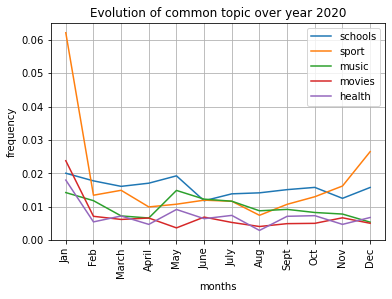

In [20]:
plt.figure()

for i,list_ in enumerate(lists_):
    count, _ ,num_quotes = topics_by_month_analysis(list_, nbr_of_topics, df_quotes_year[2], df_topics_year[2])

    plt.plot(range(1,13),np.array(count)/np.array(num_quotes),label=labels[i])


plt.ylabel("frequency")
plt.xlabel("months")
plt.xticks(range(1,13),["Jan","Feb","March","April","May","June","July","Aug","Sept","Oct","Nov","Dec"],rotation=90)
plt.grid()
plt.title(f"Evolution of common topic over year {year}")
plt.legend()
plt.savefig("results/figures/common_topics_2017.png")

In [21]:
def plot_topic_over_year(list_,label,savepath,year_init=2015,year_end=2020):
    colors = ['b','k','r','y','m','g']
    plt.figure(figsize=(10,7))

    for i,color, year,df_quotes,df_topics in zip(range(0,len(colors)),colors,years,df_quotes_year,df_topics_year):
        if years[i] <= year_end and years[i]>=year_init:
            counts,titles,num_quotes = topics_by_month_analysis(list_,0,df_quotes,df_topics)
            plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


    plt.ylabel("frequency")
    plt.xlabel("months")
    plt.xticks(range(1,13),["Jan","Feb","March","April","May","June","July","Aug","Sept","Oct","Nov","Dec"],rotation=90)
    plt.grid()
    if year_init != year_end:
        plt.title(f"Evolution of quotes on {label} for the year {year_init} - {year_end}")
    else:
        plt.title(f"Evolution of quotes on {label} for the year {year_init}")

    plt.legend()
    plt.savefig(savepath)


#### 2.2.1 First topic of interest: Terrorism in 2015

2015 is infamous for the terrorism attack on Paris and therefore it will show in the frequency analysis of the topic over the month

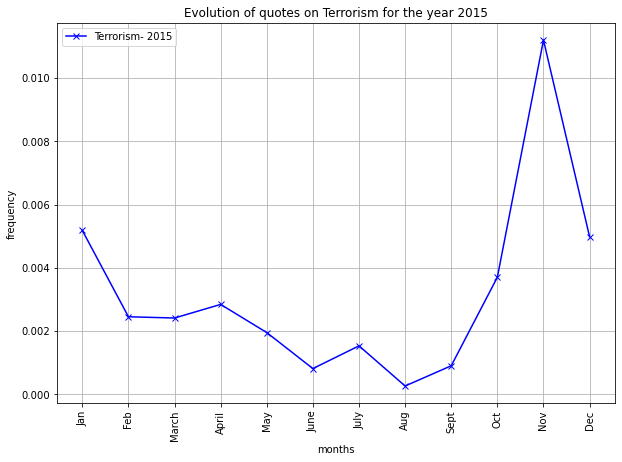

In [22]:
list_attack =["attack","terrorism","paris"]
plot_topic_over_year(list_attack,"Terrorism","results/figures/terrorism_2015.png",2015,2015)

#### 2.2.2 Second Topic of interest: Donald Trump over the years

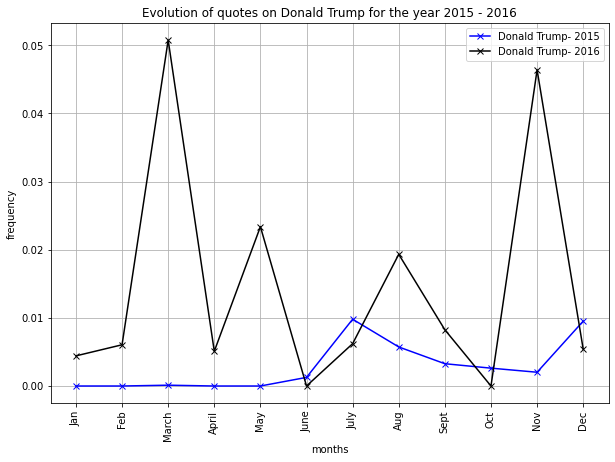

In [23]:
list_trump=["donald","trump"]
plot_topic_over_year(list_trump,"Donald Trump","results/figures/trump_2015-2020.png", 2015, 2016)

#### 2.2.3 Third Topic of interest: 

<ipython-input-21-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


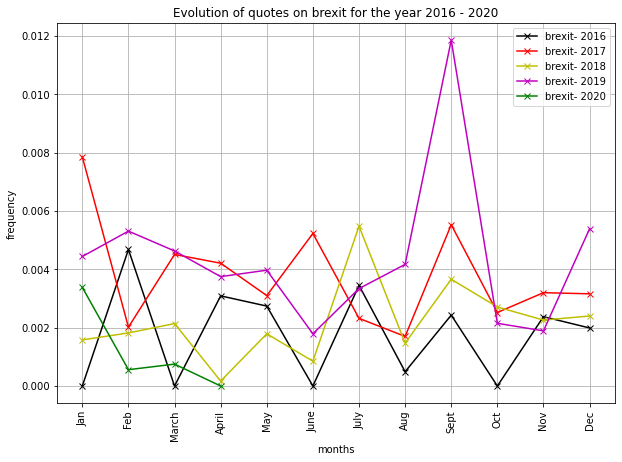

In [24]:
list_brexit=["brexit"]
plot_topic_over_year(list_brexit,"brexit","results/figures/brexit_2015-2020.png", 2016, 2020)

<ipython-input-21-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


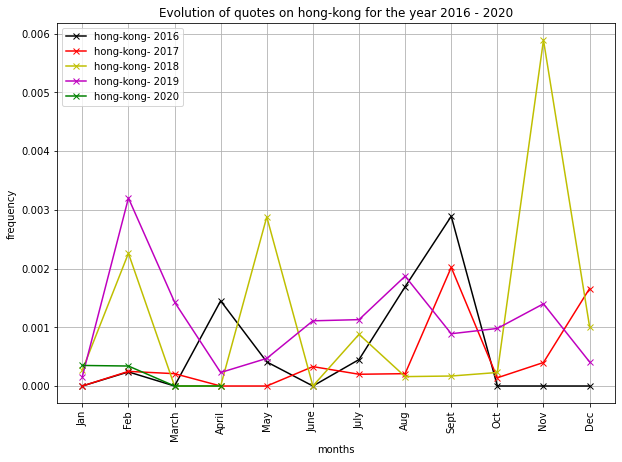

In [25]:
list_=["hong","kong","hong-kong"]
plot_topic_over_year(list_,"hong-kong","results/figures/hongkong_2015-2020.png", 2016, 2020)

### 2.3 Specific Topic Analysis  <a class="anchor" id="2-3"></a>

Until here we focused on general topics that we knew were going to be in the top topics. Here, we want to have a deeper focus on specific topic analysis which are related to specific event

#### 2.3.1 Proper Nouns Extraction

One way to detect specific topics in our analysis is to focus on proper nouns which are specific to a place or a person. When the person or place rises in terms of frequency then we can say that an event happened. In order to find out which event we can save the quotes. 

In [26]:
def extract_word_topics(df_topics_year):
    all_words = []
    for df_topics in df_topics_year:
        for row in df_topics.Words.values:
            if not(isinstance(row,type(True))):
                for word in row:
                    all_words.append(word[0])
        
    return all_words

all_words = extract_word_topics(df_topics_year)
print(all_words[0:10])

['half', 'defense', 'shots', 'game', 'points', 'win', 'played', 'second', 'ball', 'offense']


In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk import edit_distance as dist

nouns_ = []
nouns_count = []

for i,word in enumerate(all_words[0:10000]):  
    # returns a document of object
    if not(isinstance(word,type(True))):
        eps = 1e-4
        if ((i/10000.)%0.1<eps):
            print(f"Processing {i/10000*100:.2f} %")

        doc = nlp(word)

        # checking if it is a noun or not
        if(doc[0].tag_ == 'NNP'):
            exists = False

            for i,noun in enumerate(nouns_):
                if dist(noun,word) < 2:
                    nouns_count[i]+=1
                    exists = True

            if not(exists):
                nouns_.append(word)
                nouns_count.append(1)      

Processing 0.00 %
Processing 10.00 %
Processing 10.01 %
Processing 20.00 %
Processing 20.01 %
Processing 30.01 %
Processing 40.00 %
Processing 40.01 %
Processing 50.01 %
Processing 60.01 %
Processing 70.01 %
Processing 80.00 %
Processing 80.01 %
Processing 90.01 %


In [28]:
indices = np.argsort(-np.array(nouns_count))

for word,count in zip(np.array(nouns_)[indices],np.array(nouns_count)[indices]):
    if count > 4:
        print("Word:",word,"| Count:",count) 

Word: nhl | Count: 10
Word: song | Count: 8
Word: gov | Count: 8
Word: fund | Count: 6
Word: kim | Count: 6
Word: russian | Count: 6
Word: uk | Count: 6
Word: india | Count: 6
Word: house | Count: 6
Word: american | Count: 6
Word: cup | Count: 6
Word: marry | Count: 6
Word: minister | Count: 6
Word: christ | Count: 5
Word: pakistan | Count: 5
Word: gay | Count: 5
Word: mr | Count: 5
Word: mas | Count: 5
Word: bank | Count: 5
Word: sad | Count: 5
Word: ang | Count: 5
Word: nigeria | Count: 5
Word: clinton | Count: 5
Word: cuba | Count: 5
Word: va | Count: 5
Word: ufc | Count: 5


To conclude, we can observe that many topics are about countries. This is not surprising because there are a lot of international events. But citing other countries in our analysis show that there probably had an important event such as terrorism attack.

**Example of nigeria:**

<ipython-input-21-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


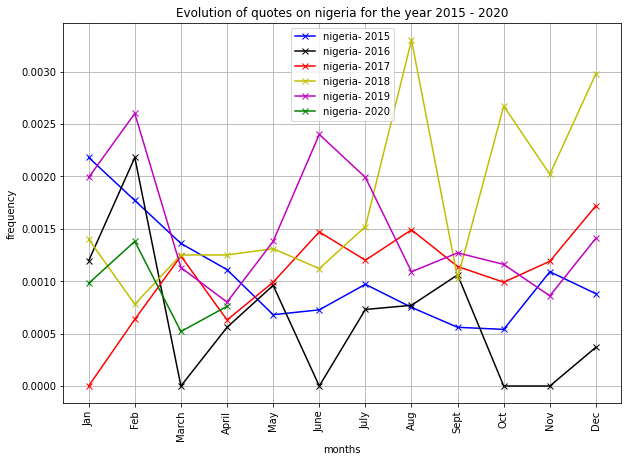

In [29]:
list_=["nigeria"]
plot_topic_over_year(list_,"nigeria","results/figures/nigeria_2015-2020.png", 2015, 2020)

In [30]:
quotes_nigeria = df_quotes_year[3][(df_quotes_year[3].date.dt.month==8) & (df_quotes_year[3].topic_number==5202)].sort_values(by=["topic_prob"],ascending=False).quotation.values

for quotes in quotes_nigeria[0:10]:
    print("----")
    print(quotes)

----
So we do hope they're paying attention.
----
There is no doubt that Nigeria is facing serious challenges which the leadership under President Muhammadu Buhari is pulling out all the stops to address. The APC administration means well for all Nigerian citizens
----
We also want to assure Tambuwal that his case will not be different from that of Ayo Fayose, as he will not only be rejected as the next governor of Sokoto state, but his presidential ambition will remain a pipe-dream as he has not only denied his people development but has wasted the scarce resources he ordinarily should have used to render service to the good people of Sokoto state. Definitely Tambuwal will go into political oblivion in 2019 as he is already running against the tide.
----
is indeed a testimony of Mr. President's integrity as his word is his bond.
----
We appeal that this commitment to protect citizens must be sustained especially at this time of the year when the military usually stage Operation Python

<ipython-input-21-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


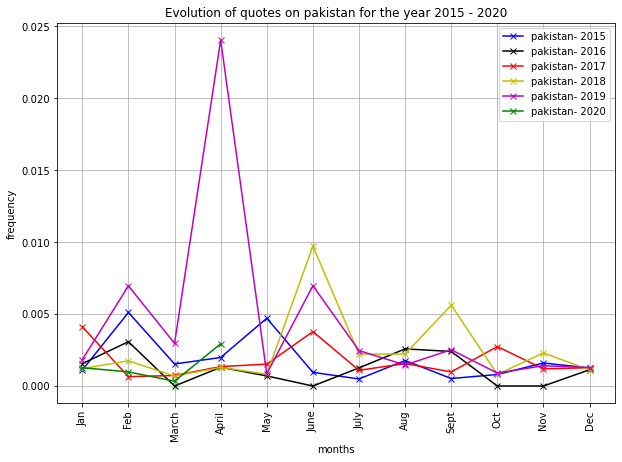

In [31]:
list_=["pakistan"]
plot_topic_over_year(list_,"pakistan","results/figures/pakistan_2015-2020.png", 2015, 2020)

In [32]:
quotes_pakistan = df_quotes_year[4][(df_quotes_year[4].date.dt.month==4) & (df_quotes_year[4].topic_number==2211)].sort_values(by=["topic_prob"],ascending=False).quotation.values

for quotes in quotes_pakistan[10:20]:
    print("----")
    print(quotes)

----
We are open for a coalition only in Delhi. We are going to declare the candidates in a day or two.
----
Reports and visuals of assaults on Kashmiri students and traders in different parts of India by the ruling Bharatiya Janata Party-backed activists are heart-wrenching and warrant for an immediate response on our part,
----
Ironically, despite living in a Muslim state, our prime minister is not able to come here and heal the wounds of the Hazara community. His claims of running Pakistan on the lines of state of Madina ring hollow,
----
The five-year Modi rule has taken a toll on the country's democratic institutions and has disturbed the social fabric of the country which takes pride in its unity in diversity,
----
We talk of issues that matter to people. Our manifesto is about the collective will of people, unlike BJP manifesto that is about one individual. Their manifesto is simply a cut-paste job of 2014 to 2019. I do not believe in using lines like Ali or Bajrangbali in my ca

This allow us to learn about the events based only on the fact that Nigeria is a proper noun and that the quotes mention issues with the current president. It shows that our analysis works and can be semi-automated to detect international events

#### 2.3.2 Lemmatization

Lemmatization allow to focus on topics that appears only once and that do not reproduce in the top 100 topics. We use only words that are almost never mentionned and look for them inside the txt file. 

In [33]:
# Common Word Extraction
from nltk.stem import LancasterStemmer

lancaster = LancasterStemmer()

# Format of the topic dataFrame
nbr_of_topics = 60

# Initialize useful Lists

# common words over year
year_words = []
year_count = []
real_words = []
# common words by month
num_quotes = []
for year, df_quotes,df_topics in zip(years,df_quotes_year,df_topics_year):
    print("Year:",year)
    for j,month in enumerate(range(1,13)):

        num_quotes.append(len(df_quotes[df_quotes.date.dt.month==month]))
        hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)

        for words,counts in zip(hot_topics[1:nbr_of_topics].Words.values,hot_topics[1:nbr_of_topics].Count.values):

            if not(isinstance(words,type(True))):
                for word in words:

                        word = word[0]
                        word_year = False     

                        for i,year_word in enumerate(year_words):
                            if lancaster.stem(word) in year_word :
                                year_count[i]+=1
                                word_year = True
                                break

                        if not(word_year):  
                            year_words.append(lancaster.stem(word))
                            real_words.append(word)
                            year_count.append(1)

Year: 2015
Year: 2016
Year: 2017
Year: 2018
Year: 2019
Year: 2020


In [34]:
print()
indices = np.argsort(np.array(year_count))
for real_word,year_word,year_count_ in zip(np.array(real_words)[indices[0:20]],np.array(year_words)[indices[0:20]],np.array(year_count)[indices[0:20]]):
    print(real_word,"|",year_word,"|",year_count_)


contraception | contraceiv | 1
surprise | surpr | 1
compound | compound | 1
columns | column | 1
datasets | dataset | 1
filibuster | filibust | 1
mcconnell | mcconnell | 1
pemex | pemex | 1
upordown | upordown | 1
amg | amg | 1
convinced | convint | 1
suffering | suff | 1
study | study | 1
oculus | ocul | 1
advertising | advert | 1
model | model | 1
heard | heard | 1
pancreatic | pancr | 1
from | from | 1
hfpa | hfpa | 1


This offers us a new way to look at topics over the year with Lemmatization, especially by looking at lem words that are almost never mentionned. Indeed, this means that they appear rarely into the topics and therefore might be specific to one event

<ipython-input-21-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


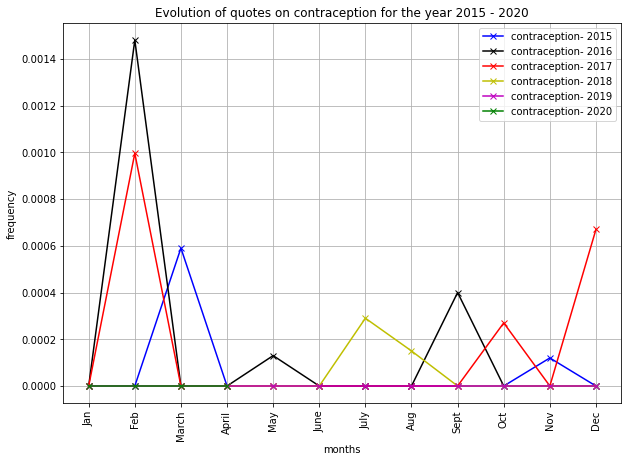

In [35]:
list_ = ["contraception"]

plot_topic_over_year(list_,"contraception","results/figures/contraception_2015-2020.png", 2015, 2020)


In [36]:
quotes_contraception = df_quotes_year[1][(df_quotes_year[1].date.dt.month==2) & (df_quotes_year[1].topic_number==146)].sort_values(by=["topic_prob"],ascending=False).quotation.values

for quotes in quotes_contraception[10:20]:
    print("----")
    print(quotes)

----
Abortion is not the lesser of two evils. It is a crime. It is to throw someone out in order to save another. That's what the Mafia does. It is a crime, an absolute evil.
----
Not only is increased access to abortion and abortifacients an illegitimate response to this crisis, but since it terminates the life of a child it is fundamentally not preventative,
----
That's now what I'm here today to debate the abortion process or debate the abortion procedure. I'm here today with this legislation, and all it does is give the woman the right to choose to be involved in the ultrasound and the determination to be fully informed on her own personal health,
----
provide coverage for all legal abortions, including voluntary and elective ones.
----
Regardless of the connection to the Zika virus... these children deserve to be protected and cared for throughout their lives, in accordance with our obligation to safeguard all human life, healthy and disabled, with equal commitment, leaving no one

## 3. Timeline Generation  <a class="anchor" id="3"></a>

**Startegy:** 

The timelines were created using Bert topic analysis outputs. Weighted lists of keywords were generated for each of the top 6 quotes of 30 topics, associated with the correponding quotes and probabilities to belonging to these topics. 

By combining them all together, we may or may not be able to understand the real-life event behind it and manually label the topic. The timeline have been constructed from thoses we were able to guess, by only using the Bert outputs. 

The number of quotes refering to these topics as well as the month the event happened, were collected. These features were then used to appropriately place the topic on the timeline : the month allows coherent ordering of the topics ; the counts have been scaled and used to set their "hotness".

### 3.1. Year 2015  <a class="anchor" id="3-1"></a>

Text(-0.3, 2.7, 'Topic hotness')

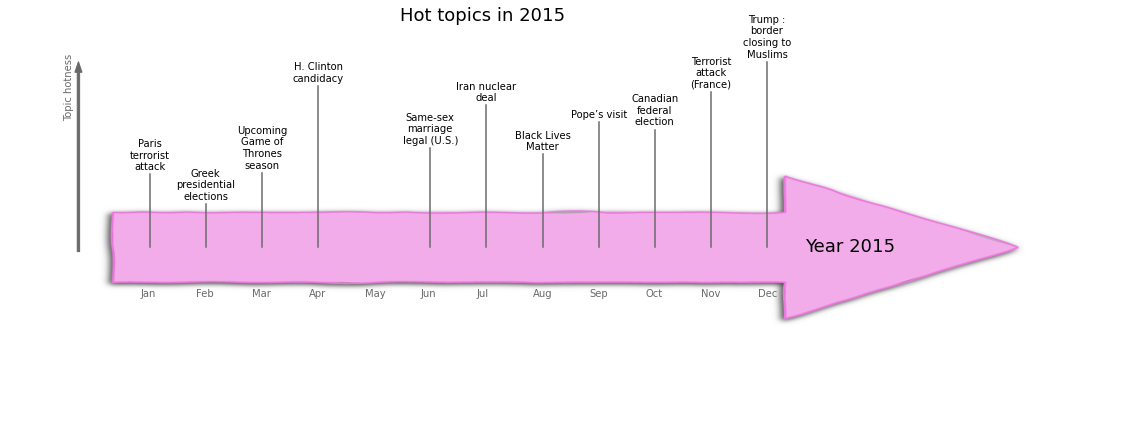

In [47]:
topics = ['Paris terrorist attack' , 'Greek presidential elections', 'Upcoming Game of Thrones season','H. Clinton candidacy','Same-sex marriage legal (U.S.)','Iran nuclear deal','Black Lives Matter' , 'Pope’s visit' , 'Canadian federal election' , 'Terrorist attack (France)' , 'Trump : border closing to Muslims']

months = [1,2,3,4,6,7,8,9,10,11,12]

counts = [270,217,273,428,317,393,306,363,350,417,471]

scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche4.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2015', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2015', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.2. Year 2016

Text(-0.3, 2.7, 'Topic hotness')

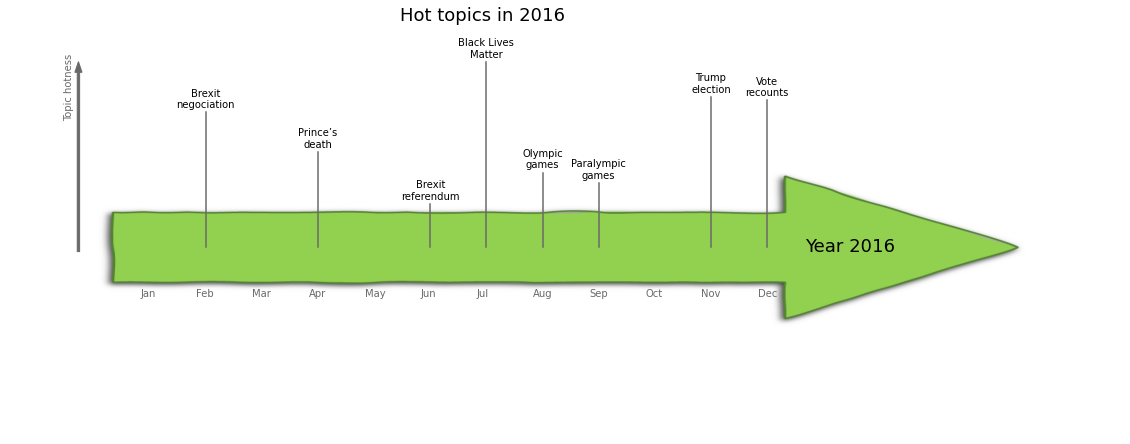

In [40]:
topics = ['Brexit negociation' , 'Prince’s death', 'Brexit referendum','Black Lives Matter','Olympic games','Paralympic games','Trump election' , 'Vote recounts']
months = [2 , 4, 6,7, 8,9,11, 12]

counts = [468 , 318 ,120 ,661, 240  , 201 , 527,514]
scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part
x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche2.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2016', fontfamily = 'cursive', fontsize = 18)

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2016', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.3. Year 2017

Text(-0.3, 2.7, 'Topic hotness')

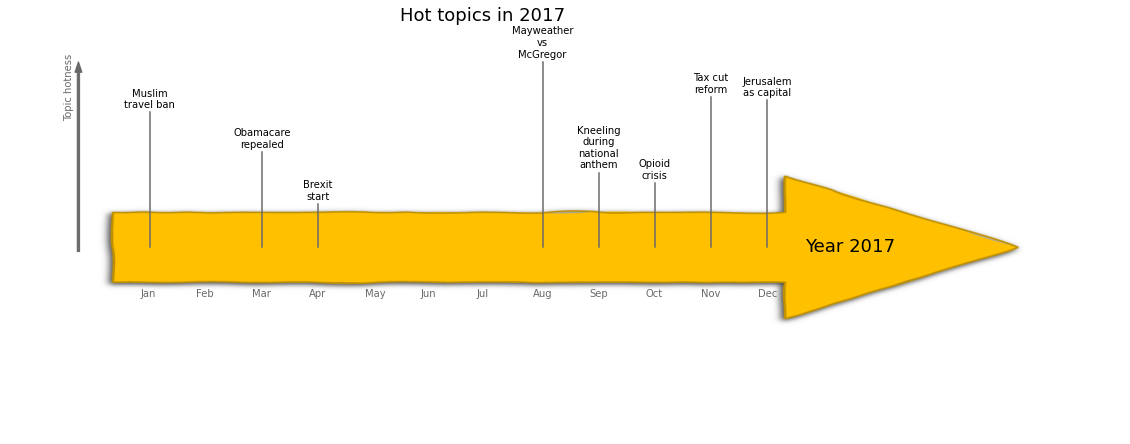

In [41]:
topics = ['Muslim travel ban' , 'Obamacare repealed', 'Brexit start','Mayweather vs McGregor','Kneeling during national anthem','Opioid crisis','Tax cut reform' , 'Jerusalem as capital']
months = [1 , 3, 4, 8,9,10,11,12]
indexes = [7 , 379, 1109 , 4099, 4927,5727,6614,7402]

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche_timeline.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2017', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(indexes)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=10)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2017', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.4. Year 2018

Text(-0.3, 2.7, 'Topic hotness')

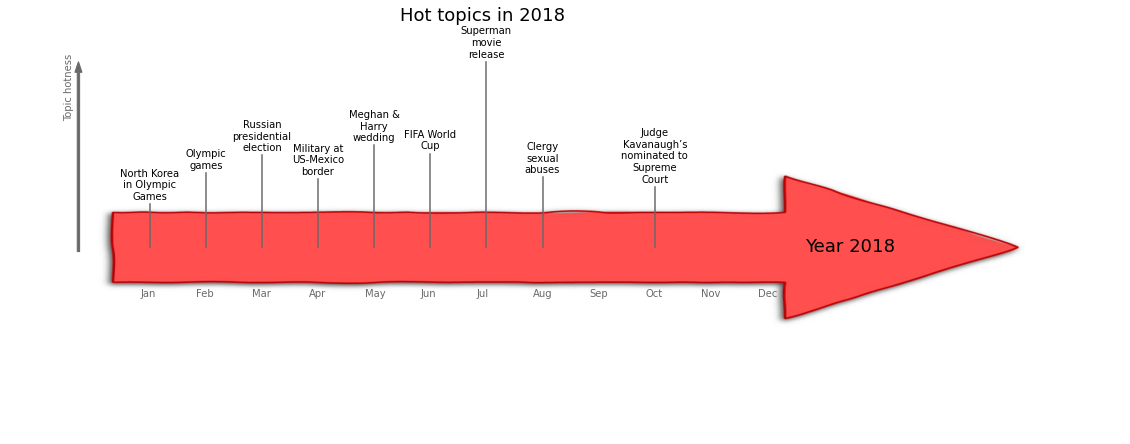

In [46]:
topics = [ 'North Korea in Olympic Games' , 'Olympic games' , 'Russian presidential election', 'Military at US-Mexico border' , 'Meghan & Harry wedding', 'FIFA World Cup', 'Superman movie release', 'Clergy sexual abuses', 'Judge Kavanaugh’s nominated to Supreme Court']

months = [1 , 2, 3, 4, 5, 6, 7, 8,10]

counts = [209 ,  348 , 425 , 320 , 469, 433 , 840, 328,286]

scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche7.jfif')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2018', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2018', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.5. Year 2019

Text(-0.3, 2.7, 'Topic hotness')

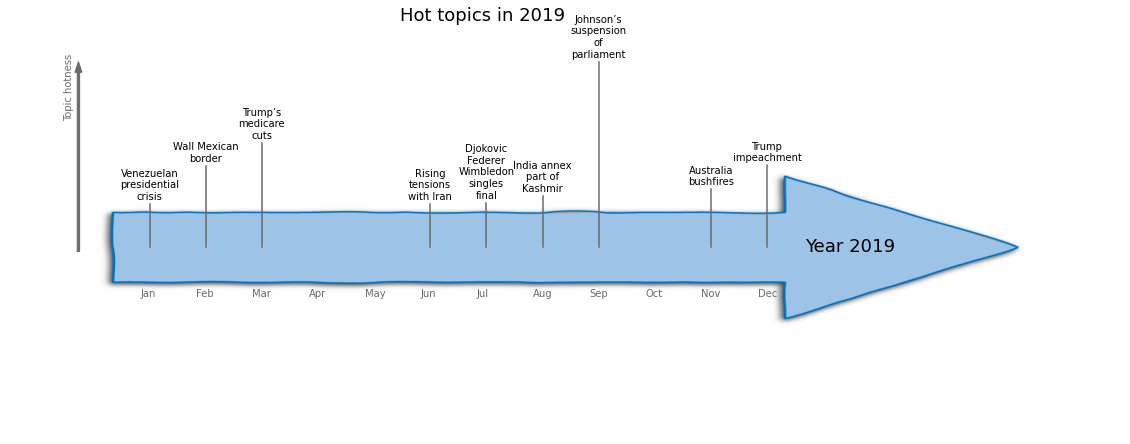

In [43]:
topics = ['Venezuelan presidential crisis' , 'Wall Mexican border', 'Trump’s medicare cuts','Rising tensions with Iran','Djokovic Federer Wimbledon singles final','India annex part of Kashmir ','Johnson’s suspension of parliament' , 'Australia bushfires' , 'Trump impeachment']
months = [1,2,3,6,7,8,9,11,12]

counts = [245 ,  478, 616 , 244 , 253, 295 , 1113, 335 ,480 ]
scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche3.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2019', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
  #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2019', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.6 Year 2020

Text(-0.3, 2.7, 'Topic hotness')

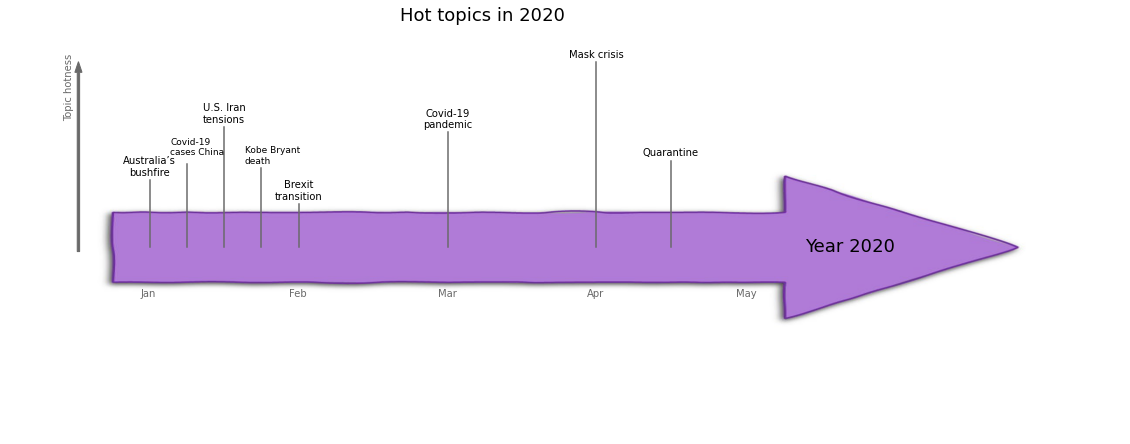

In [44]:
topics = ['Australia’s bushfire',  'Covid-19 cases China' ,'U.S. Iran tensions' , 'Kobe Bryant death' , 'Brexit transition' , 'Covid-19 pandemic' , 'Mask crisis' , 'Quarantine']
months = [1 ,1.25,1.5,1.75, 2 , 3 , 4 ,4.5]

counts = [ 325,  379,509 , 367 , 240 , 490 , 737 , 392]
scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

#x = np.linspace(1.5, 14.5, num=12)
x = np.linspace(1.5, 12*3, num=12)
gap= x[1]- x[0]
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche6.jfif')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2020', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
    plt.plot([1.5 +(months[i]-1)*gap,1.5 +(months[i]-1)*gap], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    if i == 1 or i == 3 : 
    #annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width = 25)
    plt.annotate(annot_txt, xy=(1,2),xytext=(1.15 +(months[i]-1)*gap, y[i] + 0.25 - i*0.05), ha = 'left', fontsize = 9)
    else : 
    plt.annotate(annot_txt, xy=(1,2),xytext=(1.5 +(months[i]-1)*gap, y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2020', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May'] #, 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(5): #12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

## 4. Sentiment Analysis  <a class="anchor" id="4"></a>

This code is inspired from [tutorial on how to fine-tune BERT for sentiment analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/) and adapted to our case e.g. to analyze the evolution of Trump actions.

**Question:** When an important event occurs, does the general sentiment from newspaper quotes regarding the topic evolve ?

**Strategy:** To answer the second question, and so to perform sentiment analysis, we used a fine-tuning algorithm for BERT, training the BERT sentiment classifier with data from Twitter - using 1700 complaining (negative sentiment) and 1700 non-complaining (positive sentiment) tweets. We then passed our quotes, previously regrouped into topics by BERTopic, into the trained BERT sentiment classifier and observed the evolution in percentage of positive vs negative quotes regarding a certain topic, before and after certain events occurred.


**REMARK:** The notebook is not prerun here because none of the group members have a gpu however, you can find the colab version of the sentiment analysis here: https://colab.research.google.com/drive/1qNvHMPZb7I-5kUIvgFMdWiho7yk2OQ01?usp=sharing



### 4.1 Prepare Data   <a class="anchor" id="4-1"></a>

In [52]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


Use the data collected on twiter to train the model

In [53]:
# Download twitter data to train the model
import requests
request = requests.get("https://drive.google.com/uc?export=download&id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf")
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip', mode = 'w') as zip: # to be able to write
    zip.extractall('data')

Load the external data

In [54]:
# Load data and set labels
data_complaint = pd.read_csv('data/complaint1700.csv')
data_complaint['label'] = 0
data_non_complaint = pd.read_csv('data/noncomplaint1700.csv')
data_non_complaint['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([data_complaint, data_non_complaint], axis=0).reset_index(drop=True)

# Drop 'airline' column
data.drop(['airline'], inplace=True, axis=1)

# Display 5 random samples
data.sample(5)

,id,tweet,label
775,151772,How can @SouthwestAir tell me in the AM that m...,0
2654,88625,@JetBlue what's the latest a flight can leave ...,1
386,127240,@AmericanAir 2nd plane...2nd delay... Not sure...,0
2083,31239,Kudos to @JetBlue for switching my seat on a h...,1
29,163761,@AlaskaAir had to wait a couple hours for the ...,0


In [55]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

Process the text so that it mach what we could find in a text

In [56]:
def text_preprocessing(text):
    """
    Goal:  Remove entity mentions (eg. '@') Correct errors (eg. '&amp;' to '&')
    
    Parameters:
    -----------
    text (str): a string to be processed.
    
    Outputs:
    --------
    text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

Here preprocessing such that it follows the bertopic format 

In [57]:
MAX_LEN = 256


from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    
    Parameters:
    -----------
    :data: (np.array): Array of texts to be processed.
    
    Output:
    --------
    :input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    :attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [58]:
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [61]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### 4.2 Define the model   <a class="anchor" id="4-2"></a>

Define the model to perform the sentiment analysis

In [62]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        Parmeters:
        ----------
        :bert: a BertModel object
        :classifier: a torch.nn.Module classifier
        :freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [63]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [64]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [65]:
set_seed(666)    # Set seed for reproducibility, 46
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


KeyboardInterrupt: 

In [66]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [21]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.689181   |     -      |     -     |   16.30  
   1    |   40    |   0.601341   |     -      |     -     |   15.36  
   1    |   60    |   0.550445   |     -      |     -     |   15.30  
   1    |   80    |   0.486441   |     -      |     -     |   15.29  
   1    |   100   |   0.489178   |     -      |     -     |   15.30  
   1    |   106   |   0.454704   |     -      |     -     |   4.05   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.345650   |     -      |     -     |   16.07  
   2    |   40    |   0.334913   |     -      |     -     |   15.31  
   2    |   60    |   0.332813   |     -      |     -     |   15.3

**Test Data on the model:**

In [ ]:
df_quotes = df_quotes_year[0]
test_data_1 = df_quotes[df_quotes['topic_number'] == 25]
test_data_2 = df_quotes[df_quotes['topic_number'] == 737]
test_data_3 = df_quotes[df_quotes['topic_number'] == 2235]
test_data_4 = df_quotes[df_quotes['topic_number'] == 2985]
test_data_5 = df_quotes[df_quotes['topic_number'] == 3699]
test_data_6 = df_quotes[df_quotes['topic_number'] == 4445]
test_data_7 = df_quotes[df_quotes['topic_number'] == 5166]
test_data_8 = df_quotes[df_quotes['topic_number'] == 5878]

This function computes the number of positive and negative quotes in our data sets

In [22]:
def calc_emotion(topic_number,dataset,threshold=0.7):
    
    # Run `preprocessing_for_bert` on the test set
    print('Tokenizing data...')
    test_data = dataset[dataset['topic_number']==topic_number]
    test_inputs, test_masks = preprocessing_for_bert(test_data)

    # Create the DataLoader for our test set
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)

    # Get predictions from the probabilities
    preds = np.where(probs[:, 1] > threshold, 1, 0)

    # Number of quotes predicted non-negative
    print("Number of positive quotes predicted: ", preds.sum()/len(test_data))
    return preds.sum()/len(test_data)

### 4.3 Run the model and Outputs   <a class="anchor" id="4-3"></a>

Plot the emotion by topic and by year 

**List of interesting topics and month for Trump Sentiment Analysis**


* topic_numbers_2015 = [4652,6176,8441]
* month_list = ['July','September','December']

* topic_numbers_2016 = [104,868,1681,3138,4652,4787]
* month_list = ['February','March','May','August','November','December']

* topic_numbers_2017 = [11,667,1399,2127,3614,4351,5120,6638,7363]
* month_list = ['January','March','April','May','July','August','September','November','December']

* topic_numbers_2018 = [7,1527,3757,4472,5201,5954,7386,8075]
* month_list = ['January','March','June','July','August','September','November','December']

* topic_numbers_2019 = [2237,2985,4431,5178,6633,6636,7383,8114]
* month_list = ['April','May','July','August','early-October','October','November','December']

* topic_numbers_2020 = [7]
* month_list = ['J']


In [27]:
def plot_emotion_topic_year(title,topic_numbers,month_list,dataset,threshold = 0.7):
    emotion = []
    range_of_months = len(month_list)
    for i in range(range_of_months):
    emotion.append(calc_emotion(topic_numbers[i],threshold = threshold,dataset = dataset))
    #plt.bar(y,x)
    emotion_label = [str(round(i*100,2))+'%' for i in emotion]
    print(emotion_label)
    print(emotion)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(month_list,emotion)
    ax.plot(month_list, emotion, '-b')
    ax.set_yticks(emotion)
    ax.set_yticklabels(emotion_label)
    #for n, label in enumerate(ax.yaxis.get_ticklabels()):
    #  if n >2 :
    #      label.set_visible(False)
    plt.xticks(rotation=40)
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Percentage of positive quotes')
    return

In [ ]:
emotion = []
topic_numbers = [25,737,2235,2985,3699,4445,5166,5878]
month_list = ['January','February','April','May','June','July','August','September']

range_of_months = len(month_list)

for i in range(range_of_months):
    emotion.append(calc_emotion(topic_numbers[i]))
    
print(emotion)

# Plot sentimeent analysis on China
plt.scatter(month_list,emotion)
plt.plot(month_list, emotion, '-b')
plt.title('Sentiment analysis on quotes about China')
plt.xlabel('Months')
plt.ylabel('Percentage of the positive quotes')

Accuracy of the model

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.8
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of quotes predicted non-negative
print("Number of positive quotes predicted: ", preds.sum())

In [ ]:
print(test_dataset[preds == 0])
output = test_dataset[preds == 0]